In [1]:
# Import libraries of interest
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import json
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, precision_score
from sklearn.metrics import roc_curve, auc
from sklearn.decomposition import PCA
from sklearn.feature_extraction import FeatureHasher
from collections import Counter
import category_encoders as ce
from statsmodels.tools import categorical

# Introduction 

## The Problem 
One of the many challenges in hospital clinical management is patients not showing up to their appointments. This is a loss of time and resources for hospitals who have to bear the cost of individuals' failure to attend their doctor's meeting. A potential way to prevent this issue from happening is to develop a system that predicts whether a patient will show up to the appointment or not. This way, hospitals can be prepared to reallocate resources when a patient is prone to miss their appointments. 

# Data Engineering
The data is structured in a way such that each row is an observation numbered by the variable _AppointmentID_ with a total of 110.527 medical appointments. Each observation contains the unique patient identifier called _PatientID_ (a total of 62.229 patients), the day the appointment was scheduled, the day it took place, and some demographic and clinical data including: gender, age, hypertencion diagnosis, or diabetes diagnosis. 

### Preliminary data assessment
The first step before diving into data analyisis is to assess the data provided. We will identify missing data points and outliers.


In [2]:
# Import settings
with open("settings.json", "r") as inFile:
    settings = json.load(inFile)
    
# Import data
data = pd.read_csv(settings['file']['data'])    

# Insight of the data 
data.head()


,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [3]:
# Data info
data.dtypes

PatientId         float64
AppointmentID       int64
Gender             object
ScheduledDay       object
AppointmentDay     object
Age                 int64
Neighbourhood      object
Scholarship         int64
Hipertension        int64
Diabetes            int64
Alcoholism          int64
Handcap             int64
SMS_received        int64
No-show            object
dtype: object

It is unclear what the target or dependent variable _No-Show_ means, and whether a "No" value means that the patient showed or did not show up to the appointment. The proportion of "No" values in _No-Show_ is of about 80% - we will assume that the majority actually showed up in the appointment, and that therefore a "No" means that they they did not fail to attend it. 

In [4]:
# Percentage of values in No-Show
counts_Show = Counter(data['No-show']) 
[{key: (counts_Show[key] / len(data))*100} for key in counts_Show]


[{'No': 79.8067440534892}, {'Yes': 20.193255946510806}]

We proceed to:
- Change the data columns' names and correcto typos
- Convert categorical variables to string format - this will be used for the classification algorithm.

In [5]:
# Change column names in dataframe 
data.columns = ['PatientID', 'AppointmentID', 'Gender', 'ScheduledDay', 
                'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship',
                'Hypertension', 'Diabetes', 'Alcoholism', 'Handicap', 'SMS_received', 'Show']

# Change format: object to string variable, binary to int, date to dates
data.PatientID = data.PatientID.astype(int); data.PatientID.astype(str)
data.AppointmentID = data.AppointmentID.astype('str')
data.Show = data['Show'] == "No"; data.Show = data.Show.apply(int)
data.ScheduledDay = data.ScheduledDay.astype('datetime64[ns]')
data.AppointmentDay = data.AppointmentDay.astype('datetime64[ns]')
data.Gender = data.Gender == "M"; data.Gender = data.Gender.astype(int)

# Print
data.head()

,PatientID,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,Show
0,29872499824296,5642903,0,2016-04-29 18:38:08,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,1
1,558997776694438,5642503,1,2016-04-29 16:08:27,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,1
2,4262962299951,5642549,0,2016-04-29 16:19:04,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,1
3,867951213174,5642828,0,2016-04-29 17:29:31,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,1
4,8841186448183,5642494,0,2016-04-29 16:07:23,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,1


Note: the variable _No-show_ has been named _Show_ where a value of 1 means that the patient attended the appointment, and that the hour of _AppointmentDay_ has been removed since all were equal.

In [6]:
# Check if NAs
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientID         110527 non-null int64
AppointmentID     110527 non-null object
Gender            110527 non-null int64
ScheduledDay      110527 non-null datetime64[ns]
AppointmentDay    110527 non-null datetime64[ns]
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hypertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handicap          110527 non-null int64
SMS_received      110527 non-null int64
Show              110527 non-null int64
dtypes: datetime64[ns](2), int64(10), object(2)
memory usage: 11.8+ MB


No missing values were found in any of the variables. We proceed to check that the number of patients provided in the description matches the patients in the dateset.

In [7]:
# Check if patients have multiple appointments
len(np.unique(data.PatientID))

62299

Following, we will ensure that the _AppointmentID_ variable is a unique identifier for each observation.

In [8]:
# Check that there are no appointmentID duplicates
len(np.unique(data.AppointmentID)) == len(data)

True

We found no duplicates in the _ApointmentID_. We proceed to compute the range of variables of importance.

In [9]:
# Check the range of dates in AppointmentDay and ScheduledDay
print("Range of AppointmentDay: " + str(min(data.AppointmentDay)) + " to " +  str(max(data.AppointmentDay))) 
print("Range of ScheduledDay: " + str(min(data.ScheduledDay)) + " to " +  str(max(data.ScheduledDay))) 

Range of AppointmentDay: 2016-04-29 00:00:00 to 2016-06-08 00:00:00
Range of ScheduledDay: 2015-11-10 07:13:56 to 2016-06-08 20:07:23


The format of the dates are: YY-MM-DD HH:MM:SS, and it seems that _AppointmentDay_ means the day the appointment takes place, and _ScheduledDay_ the day the appointment was made since the first chronological _ScheduledDay_ took place months before the first _AppointmentDay_. 

In [10]:
# Check age range 
print(sorted(np.unique(data.Age)))

[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 102, 115]


Two concerns arise from the age range of the population:
- Negative age: these values are clearly impossible and must be removed from the dataset. 
- Althought possible, it is highly unlikely to find ages over 100 years. Additionally, those subjects will most likely rely on their families to attend the doctors, and therefore age does not represent a variable of interest. 

It is assumed that values of 0 belong to newborns before the age of 1. Further analysis is needed, as it follows.

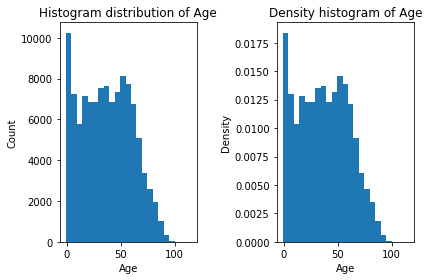

In [11]:
%matplotlib inline
fig, ax = plt.subplots(1,2)
ax[0].set_title('Histogram distribution of Age')
ax[0].set_xlabel('Age')
ax[0].set_ylabel('Count')
ax[0].hist(data.Age, bins = 23)
ax[1].set_title('Density histogram of Age')
ax[1].set_xlabel('Age')
ax[1].set_ylabel('Density')
ax[1].hist(data.Age, bins = 23, density = True)
fig.tight_layout()
plt.show()

Clearly, very few observations belong to ages older than 95. For such reason, they will also be removed.

In [12]:
data = data[data.Age.lt(95) & data.Age.ge(0)]
print("Number of observations: " + str(len(data)))

Number of observations: 110456


### Variable computation
Some potential variables that could be of interest are not explicitly included in data. The following variables will be included as part of the analysis:
- Time of the _ScheduledDay_
- Weekday the appointment takes place based on _AppointmentDay_
- Difference in days between the day the appointment was made and the day the appointment takes place as the difference between _ScheduledDay_ and _AppointmentDay_, named _WaitingTime_


In [13]:
# Create variable TimeScheduled
data['TimeScheduled'] = data.ScheduledDay.dt.hour

# Get day of the week 
data['WeekdayAppointment'] = data.AppointmentDay.dt.day_name()

# Get difference in days 
data['WaitingTime'] = np.abs(data.AppointmentDay - data.ScheduledDay)
data.WaitingTime = data.WaitingTime.dt.days

# Convert ScheduledDay to date 
data.ScheduledDay = data.ScheduledDay.dt.date

# Pring first rows 
data.head()

,PatientID,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,Show,TimeScheduled,WeekdayAppointment,WaitingTime
0,29872499824296,5642903,0,2016-04-29,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,1,18,Friday,0
1,558997776694438,5642503,1,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,1,16,Friday,0
2,4262962299951,5642549,0,2016-04-29,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,1,16,Friday,0
3,867951213174,5642828,0,2016-04-29,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,1,17,Friday,0
4,8841186448183,5642494,0,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,1,16,Friday,0


## Exploratory Data Analysis
In this section we provide a simple visualization of the dataset in order to study the dependent variable or target _Show_. First of all, we will study the distribution of the dependent variable as a function of  gender.

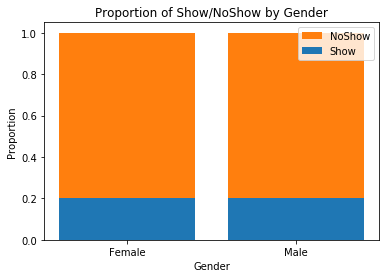

In [15]:
# Compute proportions
def comp_prop(data, Var):
    data_out = []
    for lvl in np.unique(data[Var]):
        lvl_dict = {'Var': Var}
        L =  len(data[data[Var].eq(lvl)])
        n_Show = len(data[data[Var].eq(lvl) & data.Show.eq(1)])
        n_NoShow =len(data[data[Var].eq(lvl) & data.Show.eq(0)])
        propShow, propNoShow = n_Show/L, n_NoShow/L
        lvl_dict.update({'Level': lvl, "PropShow": propShow, "PropNoShow": propNoShow})
        data_out.append(lvl_dict)
    return pd.DataFrame(data_out)

data_out = comp_prop(data, 'Gender')
plt.figure()
p2 = plt.bar(x = data_out.Level, height = data_out.PropNoShow)
p1 = plt.bar(x = data_out.Level, height = data_out.PropShow, bottom=data_out.PropNoShow)
plt.xlabel('Gender')
plt.ylabel('Proportion')
plt.title('Proportion of Show/NoShow by Gender')
plt.xticks(data_out.Level, ("Female", "Male",))
plt.legend((p1[0], p2[0]), ('NoShow', 'Show'))

plt.show()


_Gender_ does not seem to be a good indicator to discern whehter a patient will attent the appointment.

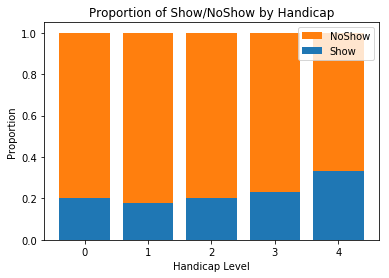

In [17]:
data_out = comp_prop(data, 'Handicap')
plt.figure()
p2 = plt.bar(x = data_out.Level, height = data_out.PropNoShow)
p1 = plt.bar(x = data_out.Level, height = data_out.PropShow, bottom=data_out.PropNoShow)
plt.xlabel('Handicap Level')
plt.ylabel('Proportion')
plt.title('Proportion of Show/NoShow by Handicap')
plt.xticks(data_out.Level, np.unique(data.Handicap))
plt.legend((p1[0], p2[0]), ('NoShow', 'Show'))

plt.show()

Contrarily to _Gender_, the level of _Handicap_ provides better information for differentiation (especially Level 4).

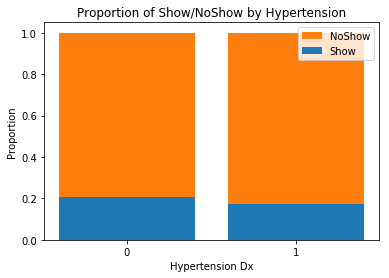

In [18]:
data_out = comp_prop(data, 'Hypertension')
plt.figure()
p2 = plt.bar(x = data_out.Level, height = data_out.PropNoShow)
p1 = plt.bar(x = data_out.Level, height = data_out.PropShow, bottom=data_out.PropNoShow)
plt.xlabel('Hypertension Dx')
plt.ylabel('Proportion')
plt.title('Proportion of Show/NoShow by Hypertension')
plt.xticks(data_out.Level, np.unique(data.Handicap))
plt.legend((p1[0], p2[0]), ('NoShow', 'Show'))

plt.show()

Similarly to _Gender_, _Hypertension_ does not seem to provide sufficient information to differentiate the dependant variable.

Text(0, 0.5, 'Proportion')

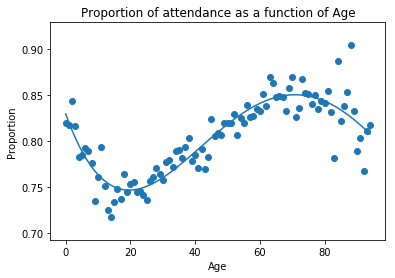

In [22]:
data_out = comp_prop(data, 'Age')
plt.figure()
plt.scatter(data_out.Level, data_out.PropShow)
trend = np.polyfit(data_out.Level, data_out.PropShow, 4)
p = np.poly1d(trend)
plt.plot(data_out.Level, p(data_out.Level), '-')
plt.title('Proportion of attendance as a function of Age')
plt.xlabel('Age')
plt.ylabel('Proportion')

Text(0, 0.5, 'Probability')

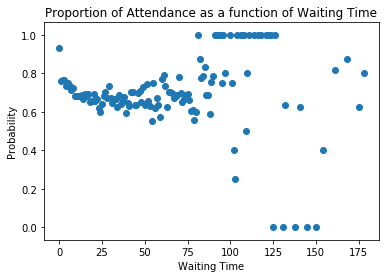

In [23]:
data_out = comp_prop(data, 'WaitingTime')
plt.figure()
plt.scatter(data_out.Level, data_out.PropShow)
plt.title('Proportion of Attendance as a function of Waiting Time')
plt.xlabel('Waiting Time')
plt.ylabel('Probability')

We conclude that variables such as _Gender_ alone do not contribute to our predictions about whether a patient will show up or not to the appointment. On the other hand, we perceive differences in the proportion of patients with a level of 4 in _Handicap_ with respect to the rest of the population. In addition, _Age_ seems to provide valuable information regarding the probability of attendance. Finally, we see that, as _WaitingTime_ increases, the probability of attendance scatters.

### Dataset Preparation
We proceed to prepare the final dataset that we will use for the classification algorithm.

In [36]:
# Dataset preparation 
data_prep = data[['Gender', 'ScheduledDay',
                  'AppointmentDay', 'Age', 
                  'Scholarship', 'Hypertension',
                  'Diabetes', 'Alcoholism', 
                  'Handicap','SMS_received', 'Show',
                  'TimeScheduled','Neighbourhood', 
                  'WeekdayAppointment','WaitingTime']]

# Data types 
data_prep.dtypes

Gender                         int64
ScheduledDay                  object
AppointmentDay        datetime64[ns]
Age                            int64
Scholarship                    int64
Hypertension                   int64
Diabetes                       int64
Alcoholism                     int64
Handicap                       int64
SMS_received                   int64
Show                           int64
TimeScheduled                  int64
Neighbourhood                 object
WeekdayAppointment            object
WaitingTime                    int64
dtype: object

We will perform the **Hashing-Trick** in order to compute numerical variables from the categorical variables so that they can be handled by the algorithm. We chose this method over One Hot Encoding because of the large number of categories in variable such as _Neighbourhood_ or _AppointmentDay_.

In [37]:
# Hashing trick on Neighbourhood
nF = 10
FH = FeatureHasher(n_features = nF, input_type = "string")
featsNeigh = FH.fit_transform(data_prep.Neighbourhood.astype('str'))
featsNeigh = pd.DataFrame(data = featsNeigh.toarray(), columns = ["Neigh_" + str(i) for i in range(1, nF+1)])

# Hashing trick on Weekday
nF = 2
FH = FeatureHasher(n_features = nF, input_type = "string")
fWD = FH.fit_transform(data_prep.WeekdayAppointment.astype('str'))
fWD = pd.DataFrame(data = fWD.toarray(), columns = ["Weekday_" + str(i) for i in range(1, nF+1)])

# Hashing trick on ScheduledDay
nF = 3
FH = FeatureHasher(n_features = nF, input_type = "string")
fSD = FH.fit_transform(data_prep.ScheduledDay.astype('str'))
fSD = pd.DataFrame(data = fSD.toarray(), columns = ["ScheduledDay_" + str(i) for i in range(1, nF+1)])

# Hashing trick on AppointmentDay
nF = 3
FH = FeatureHasher(n_features = nF, input_type = "string")
fAD = FH.fit_transform(data_prep.AppointmentDay.astype('str'))
fAD = pd.DataFrame(data = fAD.toarray(), columns = ["AppointmentdDay_" + str(i) for i in range(1, nF+1)])

# Merge to dataframe 
data_final = data_prep[['Gender', 'Age', 'Scholarship', 'Hypertension', 'Diabetes', 'Alcoholism', 'Handicap', 'SMS_received','TimeScheduled','WaitingTime', 'Show']]
data_final = pd.concat([data_final.reset_index(drop = True), featsNeigh, fWD, fSD, fAD, fPID], axis=1)

# Show
data_final.head()

,Gender,Age,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,TimeScheduled,WaitingTime,...,Weekday_2,ScheduledDay_1,ScheduledDay_2,ScheduledDay_3,AppointmentdDay_1,AppointmentdDay_2,AppointmentdDay_3,PatientID_1,PatientID_2,PatientID_3
0,0,62,0,1,0,0,0,0,18,0,...,1.0,2.0,-5.0,1.0,2.0,-5.0,1.0,2.0,0.0,4.0
1,1,56,0,0,0,0,0,0,16,0,...,1.0,2.0,-5.0,1.0,2.0,-5.0,1.0,1.0,0.0,6.0
2,0,62,0,0,0,0,0,0,16,0,...,1.0,2.0,-5.0,1.0,2.0,-5.0,1.0,5.0,-1.0,5.0
3,0,8,0,0,0,0,0,0,17,0,...,1.0,2.0,-5.0,1.0,2.0,-5.0,1.0,2.0,-3.0,3.0
4,0,56,0,1,1,0,0,0,16,0,...,1.0,2.0,-5.0,1.0,2.0,-5.0,1.0,-4.0,-3.0,-2.0


# Classification 
As previously mentioned, there is a significant imbalance of the dependent variable in the dataset - 80% to 20%. For this reason, we will study the classification both in an imbalanced and a balanced dataset.

## Imbalanced

In [38]:
# Unbalanced data
X, y = data_final.drop(columns = "Show"), data_final.Show
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)


### Random forest
Random forest is a simple, fast, ensemble method. This method over a decision tree will reduce bias through a voting dynamic. 

In [39]:
# Create classifier
classifier = RandomForestClassifier(n_estimators = 300,
    criterion = "gini",
    max_depth = 20, 
    min_samples_split = 2,
    min_samples_leaf = 1, 
    min_weight_fraction_leaf = 0, 
    bootstrap = True, 
    random_state = None, 
    verbose = 0, 
)

# Fit classifier
classifier.fit(X_train, y_train)

# Calculate train accuracy, precision and AUC 
y_pred_train = classifier.predict(X_train)
acc_train, prec_train = accuracy_score(y_train, y_pred_train), precision_score(y_train, y_pred_train)
fpr_train, tpr_train, thr_train = roc_curve(y_train, y_pred_train)
auc_train = auc(fpr_train, tpr_train)

# Print 
print("Training Accuracy: " + str(acc_train*100) + '%')
print("Training Precision: " + str(prec_train*100) + '%')
print("Area under ROC curve: " + str(auc_train))

# Test classifier 
y_pred_test = classifier.predict(X_test)
acc_test, prec_test = accuracy_score(y_test, y_pred_test), precision_score(y_test, y_pred_test)
fpr_test, tpr_test, thr_test = roc_curve(y_test, y_pred_test)
auc_test = auc(fpr_test, tpr_test)

print("Trainin Accuracy: " + str(acc_test*100) + '%')
print("Trainin Precision: " + str(prec_test*100) + '%')
print("Area under ROC curve: " + str(auc_test))


Training Accuracy: 94.83050737852274%
Training Precision: 93.92561732149373%
Area under ROC curve: 0.8714776362053032
Trainin Accuracy: 80.45689108851133%
Trainin Precision: 80.62421127150728%
Area under ROC curve: 0.5310999241650091


As expected, the algorithm is heavily influenced by the proportion of the dependent variable. In fact, it classifies mostly every patient as a positive attendance, therefore outputing an accuracy of ~80%. It fails to correctly classify those who did not attend.

### Gradient Boosting Classifier

To prevent some of the bias from happening, we perform a gradient boosting classifier, which will sequentially ensemble each decision tree.

In [40]:
# Create classifier
classifier = GradientBoostingClassifier(loss='deviance',
    learning_rate=0.1,
    n_estimators=300,
    subsample=1.0,
    criterion='friedman_mse',
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0,
    max_depth=10,
    min_impurity_decrease=0,
    min_impurity_split=None,
    init=None,
    random_state=None, 
    verbose=1)

# Fit classifier
classifier.fit(X_train, y_train)

# Calculate train accuracy, precision and AUC 
y_pred_train = classifier.predict(X_train)
acc_train, prec_train = accuracy_score(y_train, y_pred_train), precision_score(y_train, y_pred_train)
fpr_train, tpr_train, thr_train = roc_curve(y_train, y_pred_train)
auc_train = auc(fpr_train, tpr_train)

# Print 
print("Training Accuracy: " + str(acc_train*100) + '%')
print("Training Precision: " + str(prec_train*100) + '%')
print("Area under ROC curve: " + str(auc_train))

# Test classifier 
y_pred_test = classifier.predict(X_test)
acc_test, prec_test = accuracy_score(y_test, y_pred_test), precision_score(y_test, y_pred_test)
fpr_test, tpr_test, thr_test = roc_curve(y_test, y_pred_test)
auc_test = auc(fpr_test, tpr_test)

print("Test Accuracy: " + str(acc_test*100) + '%')
print("Test Precision: " + str(prec_test*100) + '%')
print("Area under ROC curve: " + str(auc_test))


      Iter       Train Loss   Remaining Time 
         1           0.9743            7.03m
         2           0.9502            7.06m
         3           0.9292            7.11m
         4           0.9111            7.19m
         5           0.8950            7.21m
         6           0.8815            7.18m
         7           0.8689            7.14m
         8           0.8576            7.09m
         9           0.8472            7.06m
        10           0.8376            7.04m
        20           0.7664            6.79m
        30           0.7236            6.25m
        40           0.6951            5.68m
        50           0.6722            5.18m
        60           0.6564            4.67m
        70           0.6306            4.41m
        80           0.6081            4.20m
        90           0.5817            4.00m
       100           0.5614            3.77m
       200           0.3772            1.94m
       300           0.2348            0.00s
Training 

Similarly, the training accuracy shows that this model provides a better prediction with already-seen data points, and has a test accuracy slightly superior to random chance. However, the predictions are still significantly biased by the dataset.

## Balanced dataset
We will balance the dataset in order to have a better idea of how well a model will perform if given a equal proportion of dependent variables. To do that, we randomly sample the maximum number of observations given the limitation of the dependent variable. 

In [68]:
# Initialize loop
acc_train, acc_test = [], []
prec_train, prec_test = [], []
auc_train, auc_test = [], []

# Iteration
for i in range(10):
    
    # Separate 
    Show_data = data_final[data_final.Show == 1]
    NoShow_data = data_final[data_final.Show == 0]

    # Get min obs
    min_rows = min([len(Show_data), len(NoShow_data)])

    # Sample and get min 
    Show_data = Show_data.sample(frac= min_rows/(len(Show_data)))    
    NoShow_data = NoShow_data.sample(frac= min_rows/(len(NoShow_data)))    

    # Merge 
    data_preSplit =pd.concat([Show_data, NoShow_data], axis = 0)
    data_preSplit = data_preSplit.sample(frac = 1)

    # Split
    X, y = data_preSplit.drop(columns = "Show"), data_preSplit.Show
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)
    
    # Create classifier
    classifier = RandomForestClassifier(n_estimators = 300,
        criterion = "gini",
        max_depth = 20, 
        min_samples_split = 2,
        min_samples_leaf = 1, 
        min_weight_fraction_leaf = 0, 
        bootstrap = True, 
        random_state = None, 
        verbose = 0, 
    )

    # Fit classifier
    classifier.fit(X_train, y_train)

    # Calculate train accuracy, precision and AUC 
    y_pred_train = classifier.predict(X_train)
    acc, prec = accuracy_score(y_train, y_pred_train), precision_score(y_train, y_pred_train)
    fpr_train, tpr_train, thr_train = roc_curve(y_train, y_pred_train)
    auc_val = auc(fpr_train, tpr_train)
    
    # Append to vectors
    acc_train.append(acc) 
    prec_train.append(prec) 
    auc_train.append(auc_val) 

    # Test classifier 
    y_pred_test = classifier.predict(X_test)
    acc, prec = accuracy_score(y_test, y_pred_test), precision_score(y_test, y_pred_test)
    fpr_test, tpr_test, thr_test = roc_curve(y_test, y_pred_test)
    auc_val = auc(fpr_test, tpr_test)

    # Append to vectors
    acc_test.append(acc) 
    prec_test.append(prec) 
    auc_test.append(auc_val) 



In [69]:
    
# Print 
print('Mean training accuracy: {:.2f}% +- {:.2f}%'.format((np.mean(acc_train)*100), (np.std(acc_train))*100))
print('Mean training precision: {:.2f}% +- {:.2f}%'.format((np.mean(prec_train)*100), (np.std(prec_train))*100))
print('Mean area under ROC curve training: {:.2f} +- {:.2f}'.format((np.mean(auc_train)),
                                                                      (np.std(auc_train))))
print('\n')
print('Mean test accuracy: {:.2f}% +- {:.2f}%'.format((np.mean(acc_test)*100), (np.std(acc_test))*100))
print('Mean test precision: {:.2f}% +- {:.2f}%'.format((np.mean(prec_test)*100), (np.std(prec_test))*100))
print('Mean area under ROC curve test: {:.2f} +- {:.2f}'.format((np.mean(auc_test)),
                                                                      (np.std(auc_test))))


Mean training accuracy: 96.41% +- 0.07%
Mean training precision: 97.40% +- 0.10%
Mean area under ROC curve training: 0.96 +- 0.00


Mean test accuracy: 68.22% +- 0.65%
Mean test precision: 72.73% +- 0.83%
Mean area under ROC curve test: 0.68 +- 0.01


## Gradient Boosting Classifier

In [157]:
# Initialize loop
acc_train, acc_test = [], []
prec_train, prec_test = [], []
auc_train, auc_test = [], []

# Iteration
for i in range(10):
    
    # Separate 
    Show_data = data_final[data_final.Show == 1]
    NoShow_data = data_final[data_final.Show == 0]

    # Get min obs
    min_rows = min([len(Show_data), len(NoShow_data)])

    # Sample and get min 
    Show_data = Show_data.sample(frac= min_rows/(len(Show_data)))    
    NoShow_data = NoShow_data.sample(frac= min_rows/(len(NoShow_data)))    

    # Merge 
    data_preSplit =pd.concat([Show_data, NoShow_data], axis = 0)
    data_preSplit = data_preSplit.sample(frac = 1)

    # Split
    X, y = data_preSplit.drop(columns = "Show"), data_preSplit.Show
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)
    
    # Create classifier
    classifier = GradientBoostingClassifier(loss='deviance',
        learning_rate=0.1,
        n_estimators=300,
        subsample=1.0,
        criterion='friedman_mse',
        min_samples_split=2,
        min_samples_leaf=1,
        min_weight_fraction_leaf=0,
        max_depth=10,
        min_impurity_decrease=0,
        min_impurity_split=None,
        init=None,
        random_state=None, 
        verbose=0)

    # Fit classifier
    classifier.fit(X_train, y_train)

    # Calculate train accuracy, precision and AUC 
    y_pred_train = classifier.predict(X_train)
    acc, prec = accuracy_score(y_train, y_pred_train), precision_score(y_train, y_pred_train)
    fpr_train, tpr_train, thr_train = roc_curve(y_train, y_pred_train)
    auc_val = auc(fpr_train, tpr_train)
    
    # Append to vectors
    acc_train.append(acc) 
    prec_train.append(prec) 
    auc_train.append(auc_val) 

    # Test classifier 
    y_pred_test = classifier.predict(X_test)
    acc, prec = accuracy_score(y_test, y_pred_test), precision_score(y_test, y_pred_test)
    fpr_test, tpr_test, thr_test = roc_curve(y_test, y_pred_test)
    auc_val = auc(fpr_test, tpr_test)

    # Append to vectors
    acc_test.append(acc) 
    prec_test.append(prec) 
    auc_test.append(auc_val) 



In [158]:
    
# Print 
print('Mean training accuracy: {:.2f}% +- {:.2f}%'.format((np.mean(acc_train)*100), (np.std(acc_train))*100))
print('Mean training precision: {:.2f}% +- {:.2f}%'.format((np.mean(prec_train)*100), (np.std(prec_train))*100))
print('Mean area under ROC curve training: {:.2f} +- {:.2f}'.format((np.mean(auc_train)),
                                                                      (np.std(auc_train))))
print('\n')
print('Mean test accuracy: {:.2f}% +- {:.2f}%'.format((np.mean(acc_test)*100), (np.std(acc_test))*100))
print('Mean test precision: {:.2f}% +- {:.2f}%'.format((np.mean(prec_test)*100), (np.std(prec_test))*100))
print('Mean area under ROC curve test: {:.2f} +- {:.2f}'.format((np.mean(auc_test)),
                                                                      (np.std(auc_test))))


Mean training accuracy: 98.55% +- 0.19%
Mean training precision: 99.27% +- 0.15%
Mean area under ROC curve training: 0.99 +- 0.00


Mean test accuracy: 68.60% +- 0.67%
Mean test precision: 71.07% +- 1.21%
Mean area under ROC curve test: 0.69 +- 0.01


# Conclusions

We constructed two classification models for both an imbalanced and a balanced dataset. The former, are uncapable of predicting accuractly the subjects that are not attending the appointment. The latter, despite an improvement in accuracy with respet to random sampling, do not represent the reality of attendance - that is, that 80% of patients will show up to their appointments. However, both systems were capable of fitting the training data succesfully, which intuitively may means that testing accuracies can be improved. 

Due to time restrictions and for future analysis, the following considerations should be taken into account:
- The **_PatientID_** has not been included as part of the analysis. It is particularly interesting to include the _PatientID_ as part of the analysis since it will allow to account for individual tendencies, will adds a more minute level of granularity and will be subject-specific.
- Both **ensemble methods** are based on decision trees. It will be interesting to explore other methods that can accound for, for instance, the 4th order relationship between _Age_ and the probability of attending the meeting. 
- The **data** has not been explored in depth. Additionaly, little is known about interaction between variables. From a management perspective, it would be interesting to know which variables maximize the likelihood of attendance in order to tackle patients that have higher priority and ensure that they do not fail to meet their doctors.
- hypothetically, **other variables** not included in tha data could be better predictors - that is, assuming that more data can be collected. For instance, ethnicity or level of income. 
- The principal problem that hinders the classification is the **imbalanced dataset**. Several strategies may be considered in order to counterbalance this issue: using othe metrics (confusion matrices, regall, F1), using penalized models, or tackling the problem with anomaly detection instead of classification.


